# I. Entendimento do negócio

## A. Contexto 

A EletroPlaza Store é um conglomerado de lojas especializado em eletrônicos, eletrodomésticos e acessórios, com presença global. Apesar da forte presença online, **as vendas da empresa são predominantemente físicas.**

Após investimentos significativos nos setores de vendas, marketing e desenvolvimento de produtos, a empresa experimentou um grande aumento no faturamento no último ano. No entanto, **novos desafios surgiram, especialmente em compreender como as vendas se comportarão nas próximas semanas, com a aproximação da Black Friday e o Natal.**

## B. Desafio

O ano está chegando ao fim, **a Black Friday e o Natal estão se aproximando e as vendas tendem a subir exponencialmente nessa época e os dados de comparação do ano passado já não servem mais como termômetro para a empresa. **

A urgência em entender os possíveis resultados é grande, pois **a equipe de negócio tem uma meta de faturamento e está preocupada se conseguirá alcançá-la.**

## C. Objetivo

O objetivo é **construir uma solução que preveja as vendas semanais das lojas e de seus variados setores para as 5 semanas finais do ano.**

A análise deve abranger diversos setores e considerar fatores externos, como temperatura, preço do combustível e taxa de desemprego.


## D. Expectativa

Os gestores da EletroPlaza Store esperam poder:
- Definir planos;
- Organizar estoques;
- Calcular receitas;
- Decidir se farão novos investimentos ou não;
- Decidir onde devem alocar estes novos investimentos, mediante campanhas mais eficientes de marketing e vendas.


# II. Entendimento dos dados

## 0. IMPORTS

### 0.1. Importing libraries

In [3]:
import pandas             as pd
import seaborn            as sns
import numpy              as np
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

import math
import random
#import ydata_profiling

from sklearn              import preprocessing as pp
from sklearn              import ensemble as en
from sklearn              import model_selection as ms
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.svm          import SVR
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.ensemble     import GradientBoostingRegressor
from sklearn.metrics      import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from datetime             import datetime, timedelta
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor

### 0.2. Loading data

In [4]:
stores         = pd.read_csv('../test-hackday-7/stores.csv', low_memory=False)
train          = pd.read_csv('../test-hackday-7/train.csv', low_memory=False)
train_features = pd.read_csv('../test-hackday-7/train_features.csv', low_memory=False)

test           = pd.read_csv('../test-hackday-7/test.csv', low_memory=False)
test_features  = pd.read_csv('../test-hackday-7/test_features.csv', low_memory=False)

### 0.3. Helper functions

In [33]:
def jupyter_settings():
    """Definições padrões setadas para o uso o Jupyter Notebook."""
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

# Função que retorna uma tabela de únicos e suas respectivas quantidades
def tab_unique(df):
    tab_unicos = pd.DataFrame(df.nunique())
    tab_unicos.columns= ['count']
    tab_unicos['content'] = df.apply(lambda x: x.unique())
    return tab_unicos

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    mse  = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    r2   = r2_score(y, yhat)
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'MSE': mse,
                         'RMSE': rmse,
                         'R2': r2}, index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ian-g\OneDrive\Documentos\Comunidade DS\hackday7\hd7\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


NameError: name 'HTML' is not defined

In [34]:
def cross_validation(x_training,kfold,model_name,model,verbose=False):
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'K = {k}')
        validation_start_date = x_training['data'].max() - timedelta(days=k*6*7)
        validation_end_date = x_training['data'].max() - timedelta(days=(k-1)*6*7)

        # Filtrar o dataset
        training   = x_training[x_training['data'] < validation_start_date] #Resto dos dados
        validation = x_training[(x_training['data'] >= validation_start_date) & (x_training['data'] <= 
                                                       validation_end_date)] # Começo até o início do treino

        training_start = training['data'].max()
        training_end = training['data'].min()

        validation_start = validation['data'].max()
        validation_end = validation['data'].min()

        # Training and validation dataset
        # training
        xtraining = training.drop(['data','vendas_semanais','id'],axis=1)
        ytraining = training['vendas_semanais']

        # Validation
        xvalidation = validation.drop(['data','vendas_semanais','id'],axis=1)
        yvalidation = validation['vendas_semanais']

        # Como fizemos para selecionar as variáveis para o Boruta
        # Estamos selecionando os datasets de treino e validação

        # Model
        m = model.fit(xtraining,ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance - Y_test é a coluna de sales que devemos encontrar e yhat é o que nosso método prediz
        rmse = np.sqrt(mean_squared_error(np.expm1(yvalidation), np.expm1(yhat)))

        # Guardando a performance de cada iteração
        rmse_list.append(rmse)

    return pd.DataFrame({'Model Name':model_name,
         'RSME CV':np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + 
                         np.round(np.std(rmse_list),2).astype(str)},index=[0])

### 0.4. Dicionário de dados

**Arquivos**
- stores.csv - características das lojas
- train.csv - dados de treino
- features.csv - atributos complementares
- test.csv - dados de teste
- sample_submission.csv - exemplo de submissão

**train.csv**

Feature | Description
-- | --
id | identificador único do registro
loja | identificador único da loja
setor | setor específico da loja
data | semana (mês-dia) em que ocorreram as vendas
vendas_semanais | valor total das vendas semanais, em US$
feriado | se há feriado ou não na semana

**features.csv**

Feature | Description
-- | --
loja | identificador único da loja
data | semana (mês-dia) em que ocorreram as vendas
temperatura | temperatura média da loja na semana, em °C
combustivel | preço médio do combustível na semana, em US$
desconto_1 | desconto promocional especial do tipo 1
desconto_2 | desconto promocional especial do tipo 2
desconto_3 | desconto promocional especial do tipo 3
desconto_4 | desconto promocional especial do tipo 4
desconto_5 | desconto promocional especial do tipo 5
desemprego | taxa média de desemprego do país na semana
feriado | se há feriado ou não na semana
distancia_competidores | distância média entre as lojas competidoras, em polegadas
clientes | quantidades de clientes presentes na loja, em média diária, durante aquela semana

**stores.csv**

Feature | Description
-- | --
loja | identificador único da loja;
tipo | eletrônico, eletrodomésticos ou acessórios;
tamanho | tamanho da loja, unidade não definida.

## 1. DATA DESCRIPTION

### 1.1. Unir tabelas

In [35]:
df  = pd.merge(train, stores, on='loja', how='inner')
df1 = pd.merge(df, train_features, on=['loja', 'data', 'feriado'], how='inner')

### 1.2. Data Dimensions

In [36]:
print('Quantidade de linhas: {:,}'.format(df1.shape[0]))
print('Quantidade de colunas: {:,}'.format(df1.shape[1]))

Quantidade de linhas: 135,385
Quantidade de colunas: 18


### 1.3. Check NA's

In [37]:
df1.isna().sum()

id                             0
loja                           0
setor                          0
data                           0
vendas_semanais            12862
feriado                        0
tipo                           0
tamanho                    33327
temperatura                47945
combustivel                52989
desconto_1                129459
desconto_2                129510
desconto_3                129746
desconto_4                130184
desconto_5                129459
desemprego                     0
distancia_competidores    129459
clientes                       0
dtype: int64

Plano para preenchimento
- vendas_semanais - Excluir esses NA (É minha variável respostas, não da para prever)
- tamanho - Prencher com a mediana
- temperatura - Prencher com a média
- combustível - Prencher com a média
- descontos - Prencher com 0
- distancia_competidores - Prencher com um número grande (Representa que não tem competidores próximos)

In [38]:
#Descobrindo quantas lojas não tem tamanho
stores.isna().sum()

loja        0
tipo        0
tamanho    11
dtype: int64

### 1.4. Data Types

In [39]:
df1.dtypes

id                          int64
loja                        int64
setor                       int64
data                       object
vendas_semanais           float64
feriado                    object
tipo                       object
tamanho                   float64
temperatura               float64
combustivel               float64
desconto_1                float64
desconto_2                float64
desconto_3                float64
desconto_4                float64
desconto_5                float64
desemprego                float64
distancia_competidores    float64
clientes                    int64
dtype: object

### 1.5. Check duplicated

In [40]:
# Verificar a existência de registros duplicados
df1.duplicated().sum()

0

## 2. TRATAMENTO DE DADOS E FEATURE ENGINEERING

In [41]:
df2 = df1.copy()

### 2.1. Criação das Hipóteses

### 2.2. Transformar e converter

#### 2.2.1. Preencher NA´s e excluir colunas

##### 2.2.1.1. Excluir os registros com vendas semanais nula ou menor que 1

In [42]:
reg_faltantes = df2.loc[(df2['vendas_semanais'].isna()) | (df2['vendas_semanais'] < 1), :].index
df2.drop(reg_faltantes, axis=0, inplace=True)

df2.reset_index(inplace=True,drop=True)
df2.tail()

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
121991,275307,33,90,11-18,23462.71,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121992,275374,33,96,11-18,10445.16,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121993,275387,33,95,11-18,25464.21,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121994,275397,33,98,11-18,7730.53,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121995,275405,33,97,11-18,4665.16,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156


##### 2.2.1.2. Preencher os descontos com valores nulos com 0

In [43]:
df2['desconto_1'] = df2['desconto_1'].fillna(0)
df2['desconto_2'] = df2['desconto_2'].fillna(0)
df2['desconto_3'] = df2['desconto_3'].fillna(0)
df2['desconto_4'] = df2['desconto_4'].fillna(0)
df2['desconto_5'] = df2['desconto_5'].fillna(0)

##### 2.2.1.3.  Preencher o tamanho das lojas faltantes com a mediana

In [44]:
%%time
mediana = df2['tamanho'].median()
tam_faltantes = df2.loc[df2['tamanho'].isna(), :].index
df2['tamanho'] = df2['tamanho'].apply(lambda x: mediana if math.isnan(x) else x)

CPU times: total: 62.5 ms
Wall time: 44 ms


In [45]:
#Conferindo se mudou
df2.iloc[tam_faltantes, :].head(3)

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
5623,140681,3,25,01-07,2658.57,nao,eletronico,128107.0,11.861111,NaN,0.0,0.0,0.0,0.0,0.0,0.07551,NaN,901
5624,141029,3,20,01-07,1358.81,nao,eletronico,128107.0,11.861111,NaN,0.0,0.0,0.0,0.0,0.0,0.07551,NaN,901
5625,141077,3,34,01-07,3280.50,nao,eletronico,128107.0,11.861111,NaN,0.0,0.0,0.0,0.0,0.0,0.07551,NaN,901


##### 2.2.1.4. Preencher a temperatura faltantes usando a média

In [46]:
%%time
media = df2['temperatura'].mean()
temp_faltantes = df2.loc[df2['temperatura'].isna(), :].index
df2['temperatura'] = df2['temperatura'].apply(lambda x: media if math.isnan(x) else x)

CPU times: total: 31.2 ms
Wall time: 42 ms


In [47]:
#Conferindo a alteração
df2.iloc[temp_faltantes, :].head(3)

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
129,146595,17,6,01-21,4548.82,nao,eletronico,93188.0,15.710478,2.934,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,422
130,146907,17,1,01-21,16137.30,nao,eletronico,93188.0,15.710478,2.934,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,422
131,146975,17,2,01-21,39712.80,nao,eletronico,93188.0,15.710478,2.934,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,422


##### 2.2.1.5. Preencher os registros com combustível faltantes usando a média

In [48]:
%%time
media = df2['combustivel'].mean()
comb_faltantes = df2.loc[df2['combustivel'].isna(), :].index
df2['combustivel'] = df2['combustivel'].apply(lambda x: media if math.isnan(x) else x)

CPU times: total: 46.9 ms
Wall time: 42.6 ms


In [49]:
#Conferindo se mudou
df2.iloc[comb_faltantes, :].head(3)

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
377,158299,17,24,02-18,3652.30,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
378,158421,17,20,02-18,3273.07,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
379,158480,17,58,02-18,1200.00,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956


##### 2.2.1.6. Preencher os registros com distancia faltantes usando um número grande

In [50]:
%%time
comp_faltantes = df2.loc[df2['distancia_competidores'].isna(), :].index
df2['distancia_competidores'] = df2['distancia_competidores'].apply(lambda x: 300000 if math.isnan(x) else x)

CPU times: total: 62.5 ms
Wall time: 67.9 ms


In [51]:
#Conferindo se mudou
df2.iloc[comb_faltantes, :].head(3)

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
377,158299,17,24,02-18,3652.30,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
378,158421,17,20,02-18,3273.07,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
379,158480,17,58,02-18,1200.00,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956


#### 2.2.2. Transformação de tipos

In [52]:
df2.dtypes

id                          int64
loja                        int64
setor                       int64
data                       object
vendas_semanais           float64
feriado                    object
tipo                       object
tamanho                   float64
temperatura               float64
combustivel               float64
desconto_1                float64
desconto_2                float64
desconto_3                float64
desconto_4                float64
desconto_5                float64
desemprego                float64
distancia_competidores    float64
clientes                    int64
dtype: object

##### 2.2.2.1 Transformar data nas colunas dia e mes

In [53]:
# Transformar o campo data em datetime
df2['data']          = pd.to_datetime(df2['data'] + '-2023', format='%m-%d-%Y')

# Criar novas colunas para análise detalhada
df2["week_of_year"]  = df2["data"].dt.strftime("%U")
df2["week_of_month"] = df2["data"].dt.day.apply(lambda x: (x - 1) // 7 + 1)
df2['month']         = df2['data'].dt.month
df2['day']           = df2['data'].dt.day

##### 2.2.2.2. Transformar feriado em 0 e 1

In [54]:
df2['feriado'] = df2['feriado'].apply(lambda x: 1 if x == 'sim' else 0)

In [55]:
#Verificando se está certo
df2['feriado'].unique()

array([0, 1], dtype=int64)

### 2.3. Criar

#### 2.3.1. Classificar as lojas pelo tamanho

In [56]:
q1 = df2['tamanho'].quantile(0.25)
q2 = df2['tamanho'].quantile(0.5)
q3 = df2['tamanho'].quantile(0.75)

df2['tipo_de_loja'] = df2['tamanho'].apply(lambda x: 'A' if x < q1 else
                                                     'B' if x < q3 else 'C')

In [57]:
df2.loc[:, ['tipo_de_loja', 'vendas_semanais']].groupby('tipo_de_loja').median()

,vendas_semanais
tipo_de_loja,
A,4757.605
B,8734.610
C,11520.665


#### 2.3.2. Somar os desconto semana

In [58]:
df2['desconto'] = df2['desconto_1'] + df2['desconto_2'] + df2['desconto_3'] + df2['desconto_4'] + df2['desconto_5']
df2.drop(['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5'], axis=1, inplace=True)

## 3. EXPLORATORY DATA ANALYSIS (EDA)

In [80]:
df3 = df2.copy()
df3['week_of_year'] = df3['week_of_year'].astype('int64')

### 3.1. Análise Univariada

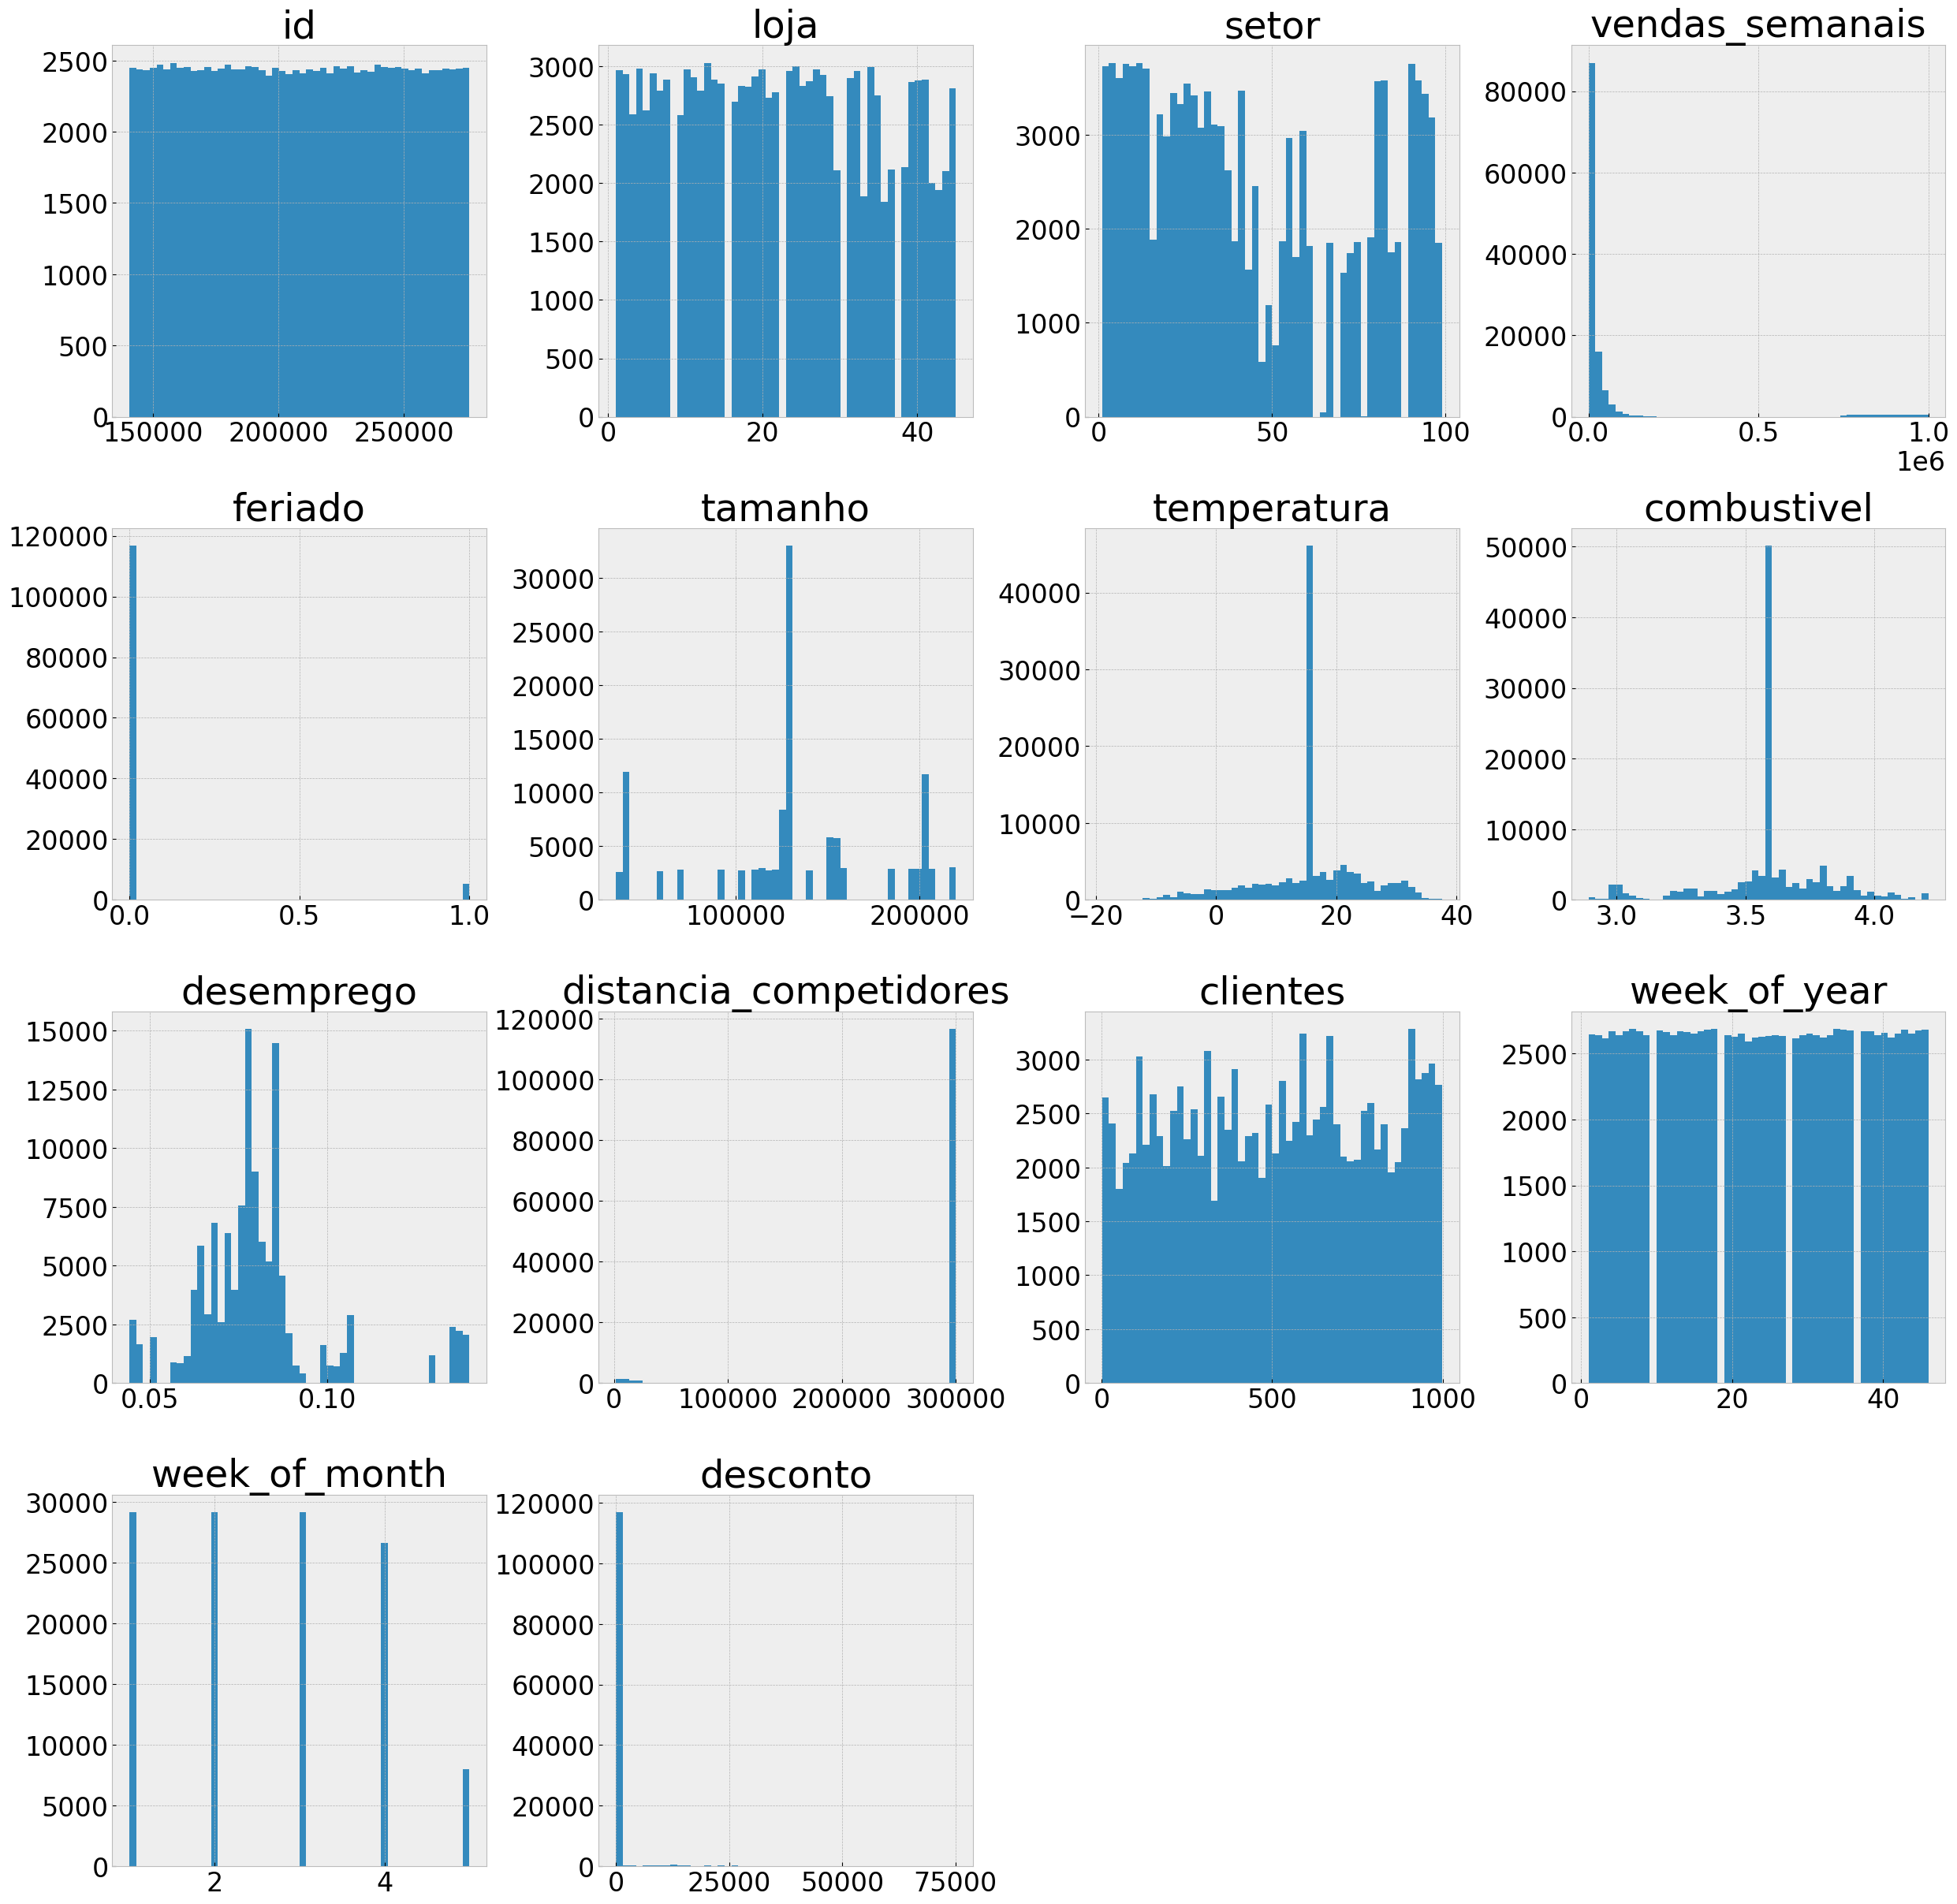

In [81]:
num_attr = df3.select_dtypes(include=['int64','float64'])
cat_attr = df3.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

num_attr.hist(bins=50,figsize=(30, 30));

#### 3.1.1. Vendas

In [30]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
id,121996.0,208327.019984,39113.291882,140679.000000,174427.75000,208328.500000,242209.250000,276063.000000
loja,121996.0,22.231221,12.785161,1.000000,11.00000,22.000000,33.000000,45.000000
setor,121996.0,44.104667,30.461675,1.000000,18.00000,37.000000,72.000000,99.000000
vendas_semanais,121996.0,63263.672589,198830.111869,1.000000,2284.54000,8310.015000,23730.082500,999967.424022
feriado,121996.0,0.043780,0.204606,0.000000,0.00000,0.000000,0.000000,1.000000
tamanho,121996.0,131427.548174,49646.107299,34875.000000,114533.00000,128107.000000,155083.000000,219622.000000
temperatura,121996.0,15.710478,8.627305,-18.922222,13.70000,15.710478,20.294444,37.588889
combustivel,121996.0,3.597230,0.223213,2.891000,3.56600,3.597230,3.682000,4.211000
desemprego,121996.0,0.080727,0.018728,0.044200,0.07082,0.078520,0.085230,0.140210
distancia_competidores,121996.0,287604.446982,57924.824269,1576.000000,300000.00000,300000.000000,300000.000000,300000.000000


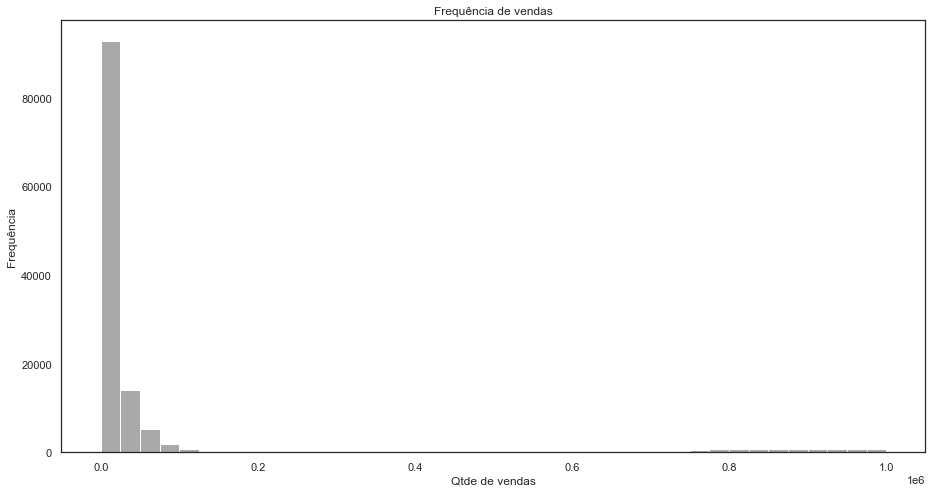

In [134]:
# Cria o gráfico
fig = plt.figure( figsize = (12, 6))
ax  = fig.add_axes([0, 0, 1, 1])

# Configura o título e os eixos
ax.set_title('Frequência de vendas')
ax.set_xlabel('Qtde de vendas')
ax.set_ylabel('Frequência')

# Plota e mostra o gráfico
ax.hist(df3['vendas_semanais'], bins=40, color='darkgrey')

plt.show()

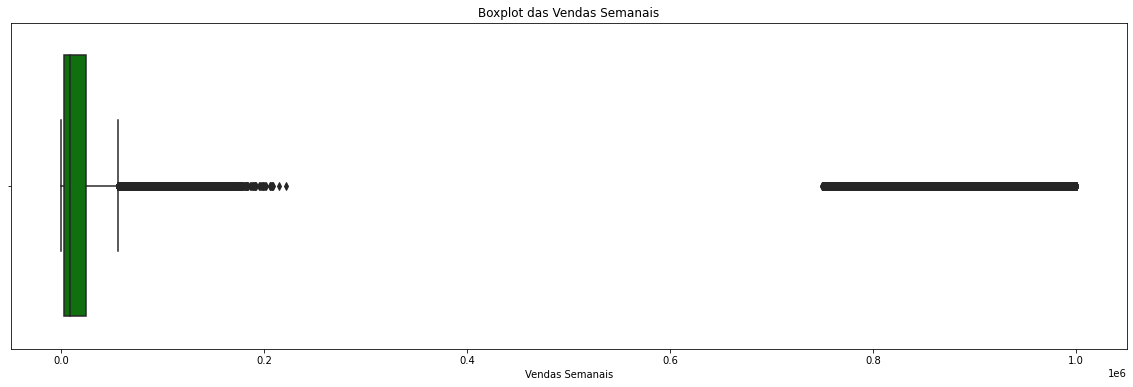

In [32]:
# Criando o boxplot
plt.figure(figsize=(20, 6)) 
sns.boxplot(x=df3['vendas_semanais'], color='green')
plt.title('Boxplot das Vendas Semanais')
plt.xlabel('Vendas Semanais')
plt.show()

##### 3.1.1.1. Análise de outliers

In [33]:
q1 = df3['vendas_semanais'].quantile(0.25)
q3 = df3['vendas_semanais'].quantile(0.75)

In [34]:
iqr = q3 - q1
iqr

21445.5425

In [35]:
limite_superior = q3 + 1.5 * iqr
limite_inferior = q1 - 1.5 * iqr

In [36]:
limite_superior

55898.396250000005

In [37]:
limite_inferior

-29883.77375

In [38]:
df3.loc[df3['vendas_semanais'] < 0, :]

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,week_of_month,month,day,tipo_de_loja,desconto


#### 3.1.2. Tamanho da loja

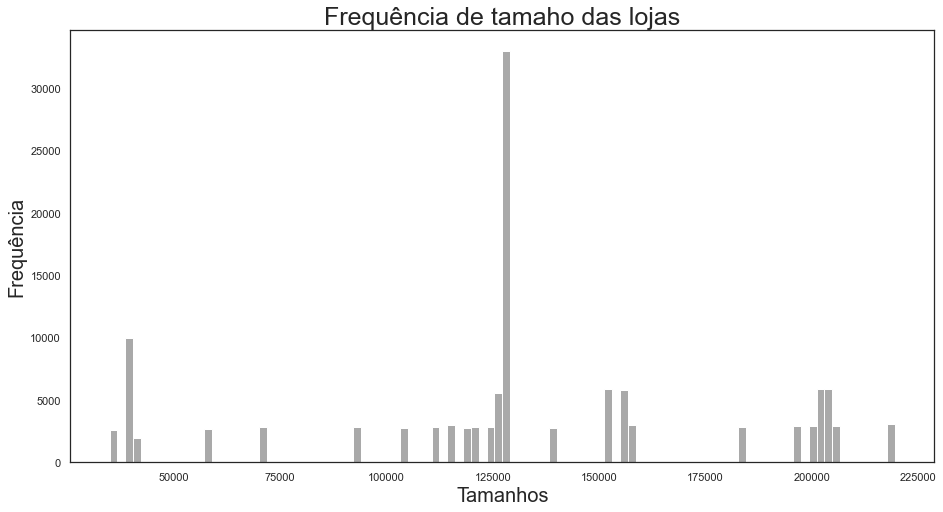

In [138]:
# Cria o gráfico
fig = plt.figure( figsize = (12, 6))
ax = fig.add_axes([0, 0, 1, 1])

# Configura o título e os eixos
ax.set_title('Frequência de tamanho das lojas', fontsize=25)
ax.set_xlabel('Tamanhos', fontsize=20)
ax.set_ylabel('Frequência', fontsize=20)

# Plota e mostra o gráfico
ax.hist(df3['tamanho'], bins=100, color='darkgrey')
plt.show()

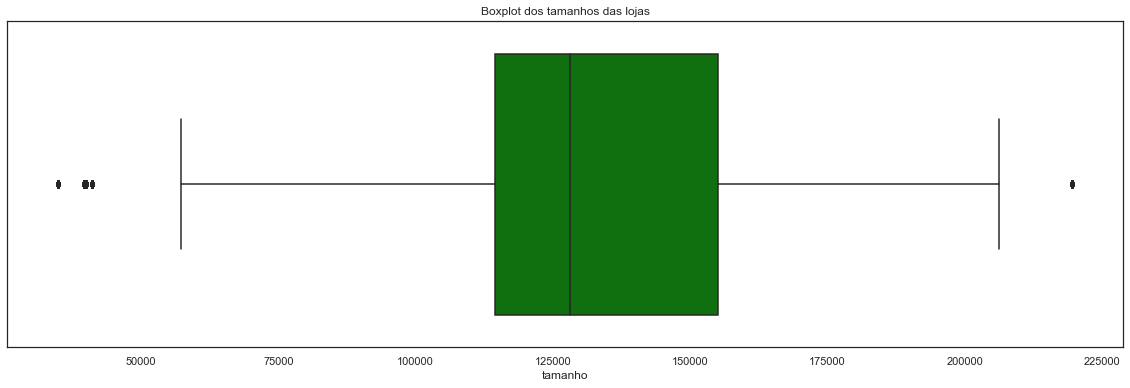

In [139]:
# Criando o boxplot
plt.figure(figsize=(20, 6)) 
sns.boxplot(x=df3['tamanho'], color='green')
plt.title('Boxplot dos tamanhos das lojas')
plt.show()

### 3.2. Análise bivariada

#### 3.2.1. Vendas por sazonalidade

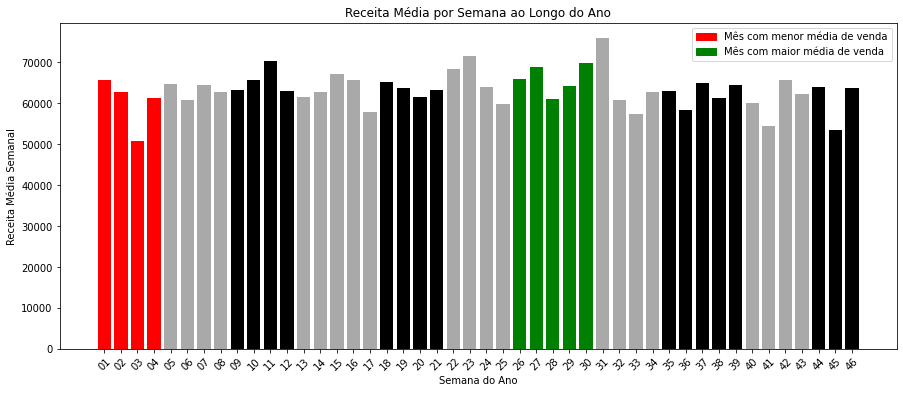

In [41]:
# Calcula a média da receita para cada semana
df_semanal = df3.groupby(['week_of_year', 'month'])['vendas_semanais'].mean().reset_index()

# Calcula a soma das vendas_semanais por mês
df_soma_mensal = df3.groupby(['month'])['vendas_semanais'].sum().reset_index()

# Encontra o mês com o maior total de vendas_semanais
mes_maior_venda = df_soma_mensal.loc[df_soma_mensal['vendas_semanais'].idxmax(), 'month']

# Encontra o mês com a menor média de vendas_semanais
mes_menor_media = df_semanal.groupby('month')['vendas_semanais'].mean().idxmin()

# Cria novas colunas indicando se o mês é o mês com as maiores ou menores vendas
df_semanal['maior_venda'] = df_semanal['month'] == mes_maior_venda
df_semanal['menor_media'] = df_semanal['month'] == mes_menor_media

# Plota o gráfico de barras
plt.figure(figsize=(15, 6))

# Destaca as semanas que representam o início de cada mês
cores = df_semanal['month'].map({1: 'black', 2: 'darkgray', 3: 'black', 4: 'darkgray', 5: 'black', 6: 'darkgray', 7: 'black', 8: 'darkgray', 9: 'black', 10: 'darkgray', 11: 'black', 12: 'darkgray'})

# Ajusta cores para destacar o mês com a menor média em vermelho
cores[df_semanal['menor_media']] = 'red'

# Barra principal
barra_principal = plt.bar(df_semanal['week_of_year'], df_semanal['vendas_semanais'], color=cores)

# Adiciona barras destacadas apenas para o mês com as maiores vendas
barra_destacada_maior_venda = plt.bar(df_semanal[df_semanal['maior_venda']]['week_of_year'], df_semanal[df_semanal['maior_venda']]['vendas_semanais'], color='green')

# Adiciona barras destacadas apenas para o mês com a menor média
barra_destacada_menor_media = plt.bar(df_semanal[df_semanal['menor_media']]['week_of_year'], df_semanal[df_semanal['menor_media']]['vendas_semanais'], color='red')

# Cria patches para as legendas
patch_green = mpatches.Patch(color='green', label='Mês com maior média de venda')
patch_red = mpatches.Patch(color='red', label='Mês com menor média de venda')

# Adiciona a legenda
plt.legend(handles=[patch_red, patch_green])

plt.xlabel('Semana do Ano')
plt.ylabel('Receita Média Semanal')
plt.title('Receita Média por Semana ao Longo do Ano')
plt.xticks(rotation=45)

plt.show()

#### 3.2.2. Vendas por tipo

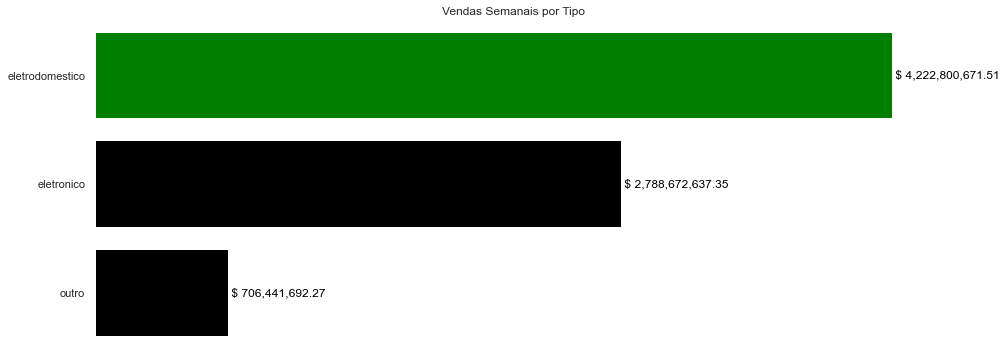

In [42]:
# Filtra e agrupa
aux = df3.groupby('tipo')['vendas_semanais'].sum().reset_index()
aux = aux.sort_values('vendas_semanais')

# Criação do gráfico de barras horizontais
plt.figure(figsize=(15, 6))

# Configuração do estilo do Seaborn
sns.set(style="whitegrid")

# Criação do gráfico de barras
ax = sns.barplot(
    x='vendas_semanais',
    y='tipo',
    data=aux.sort_values('vendas_semanais', ascending=False),
    ci=None,
    color='black'  # Define a cor preta para todas as barras
)

# Destaca a barra maior
max_index = aux['vendas_semanais'].idxmax()
ax.patches[max_index].set_facecolor('green')

# Adiciona rótulos e título ao gráfico
plt.xlabel('Vendas Semanais')
plt.ylabel('')
plt.title('Vendas Semanais por Tipo')

# Adiciona rótulos com os valores no final das barras
for i, v in enumerate(aux.sort_values('vendas_semanais', ascending=False).head(10)['vendas_semanais']):
    ax.text(v + 2, i, f' $ {v:,.2f}', color='black', ha='left', va='center')
    
# Remove o frame e os valores do eixo x
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)

# Exibe o gráfico
plt.show()

#### 3.2.3. Vendas por setor

In [43]:
# Os setores 65 e 43 só existem nas lojas 34 e 15
# Setores únicos por loja
loja_por_setor = df3.groupby('setor')['loja'].unique().reset_index()
loja_por_setor['tamanho'] = loja_por_setor['loja'].apply(lambda x: len(x))

loja_por_setor = loja_por_setor.sort_values(by='tamanho', ascending=False)
loja_por_setor

,setor,loja,tamanho
0,1,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
75,95,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
72,92,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
37,40,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
39,42,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
...,...,...,...
62,78,"[17, 12, 2, 15, 23, 16, 45, 8, 27, 13, 1, 28, ...",15
47,50,"[26, 10, 15, 23, 27, 13, 20, 18, 19, 24, 25, 1...",13
61,77,"[17, 3, 15]",3
56,65,[34],1


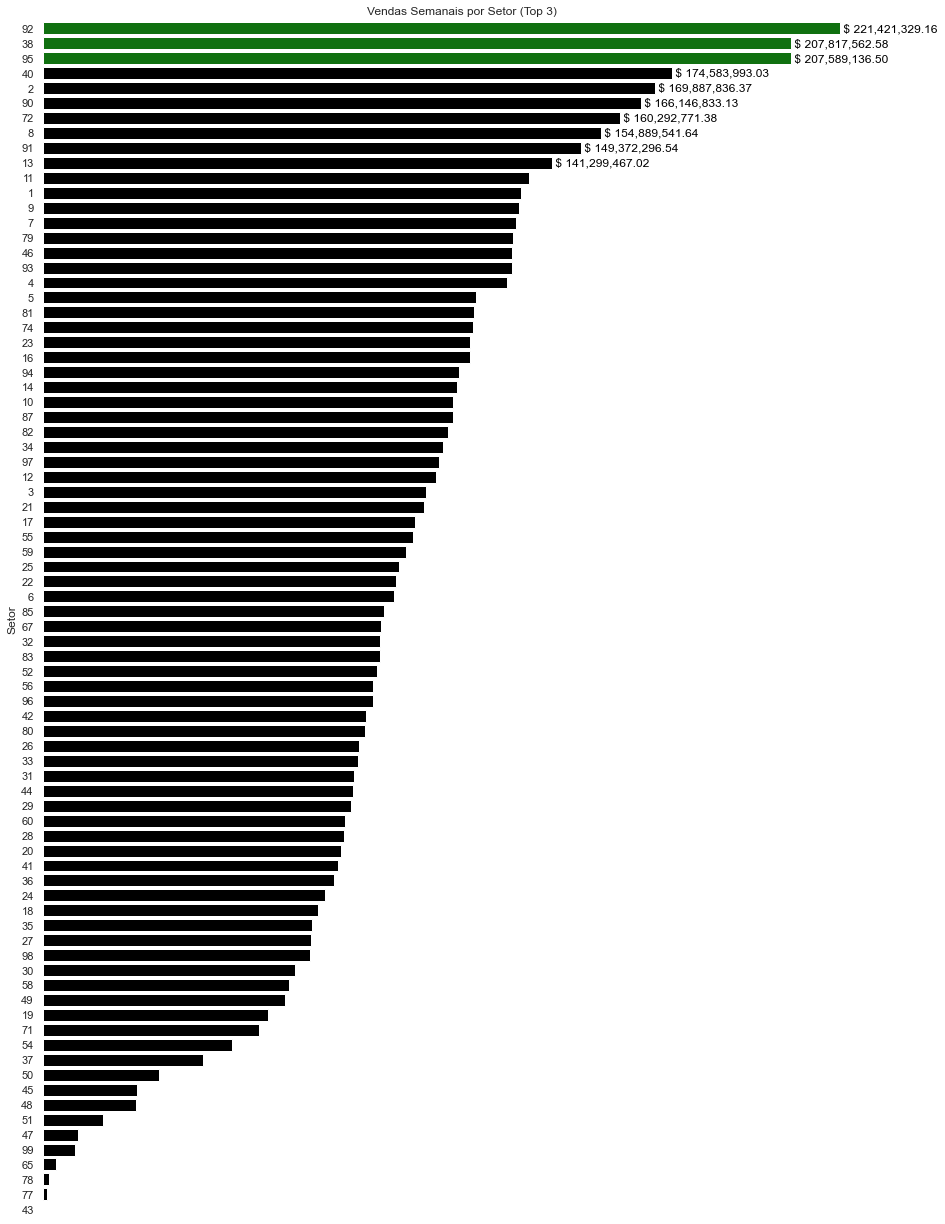

In [44]:
# Filtra e agrupa
aux = df3.groupby('setor')['vendas_semanais'].sum().reset_index()
aux = aux.sort_values('vendas_semanais')

# Convertendo 'setor' para texto
aux['setor'] = aux['setor'].astype(str)

# Calcula a média das vendas
# media_vendas = aux['vendas_semanais'].mean()

# Configuração estética opcional
sns.set(style="white")

# Criação do gráfico de barras horizontais
plt.figure(figsize=(15, 22))
ax = sns.barplot(
     x='vendas_semanais', 
     y='setor', 
     data=aux.sort_values('vendas_semanais', ascending=False), 
     ci=None, 
     palette=['green' if i < 3 else 'black' for i in range(len(aux))]
#    palette=['green' if valor > media_vendas else 'black' for valor in aux['vendas_semanais']]
)

# Adiciona rótulos e título ao gráfico
plt.xlabel('Vendas Semanais')
plt.ylabel('Setor')
plt.title('Vendas Semanais por Setor (Top 3)')

# Adiciona rótulos com os valores no final das barras
for i, v in enumerate(aux.sort_values('vendas_semanais', ascending=False).head(10)['vendas_semanais']):
    ax.text(v + 2, i, f' $ {v:,.2f}', color='black', ha='left', va='center')

# Remove o frame e os valores do eixo x
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)    

# Exibe o gráfico
plt.show()

#### 3.2.4. Vendas por desconto

In [45]:
# Filtra e agrupa
aux = df3.groupby('desconto')['vendas_semanais'].mean().reset_index()
aux

,desconto,vendas_semanais
0,0.00,63480.782438
1,603.48,55890.006910
2,979.35,62421.596967
3,1042.10,95746.232995
4,1055.91,42144.793221
...,...,...
86,59076.80,85295.918882
87,61628.71,70495.290693
88,64363.19,40554.899389
89,66157.93,47124.945089


### 3.3. Análise Multivariada

#### 3.3.1. Profile

In [46]:
#profile = ydata_profiling.ProfileReport(df3, minimal=False)

#profile = df3.profile_report(
#    correlations={
#        "pearson": {"calculate": True},
#        "spearman": {"calculate": True},
#        "kendall": {"calculate": True},
#        "cramers": {"calculate": True},
#        "phi_k": {"calculate": False},
#    },)

In [47]:
#profile

#### 3.3.2. HeatMap

C:\Users\paula\AppData\Local\Temp\ipykernel_12648\3955214122.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
C:\Users\paula\AppData\Local\Temp\ipykernel_12648\3955214122.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


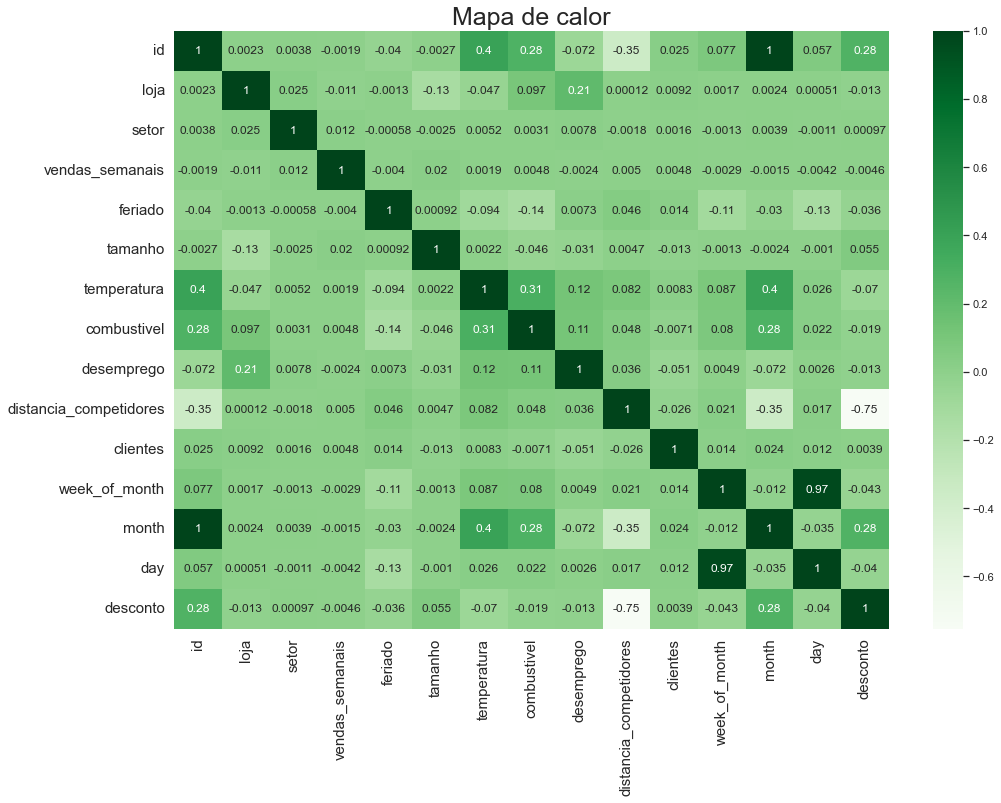

In [140]:
# Criar o mapa de calor
corr = df3.corr(method='pearson')
fig, ax = plt.subplots(figsize=(16, 11))

# Configura o título e os eixos
ax.set_title('Mapa de calor', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# Plota e mostra o gráfico
ax = sns.heatmap(corr, annot=True, cmap='Greens', ax=ax)
plt.show()

# III. Preparação dos dados

## 4. DATA PREPARATION

In [37]:
df4 = df3.copy()
df4.columns

Index(['id', 'loja', 'setor', 'data', 'vendas_semanais', 'feriado', 'tipo',
       'tamanho', 'temperatura', 'combustivel', 'desemprego',
       'distancia_competidores', 'clientes', 'week_of_year', 'week_of_month',
       'month', 'day', 'tipo_de_loja', 'desconto'],
      dtype='object')

### 4.1 Rescala de Variáveis Numéricas

In [39]:
mm = pp.MinMaxScaler()   # Mantem a mesma distribuição, com outro shape, e colocando de 0 a 1
ss = pp.StandardScaler() # Rescala os dados
rs = pp.RobustScaler()

df4['tamanho']      = ss.fit_transform(df4[['tamanho']])
df4['temperatura']  = ss.fit_transform(df4[['temperatura']])

df4['desconto']     = mm.fit_transform(df4[['desconto']])
df4['week_of_year'] = mm.fit_transform(df4[['week_of_year']])
df4['clientes']     = mm.fit_transform(df4[['clientes']])

df4['distancia_competidores'] = rs.fit_transform(df4[['distancia_competidores']])

### 4.2 Encodar Variáveis Categóricas

In [42]:
#'feriado' - One Hot Encoding
df4 = pd.get_dummies(df4,prefix=['feriado'],dtype='int64',columns=['feriado'])

#'tipo' - Label Encoding
le = pp.LabelEncoder()
df4['tipo'] = le.fit_transform(df4['tipo'])

#'tipo_de_loja' - One Hot Encoding
df4 = pd.get_dummies(df4,prefix=['tipo_de_loja'],dtype='int64',columns=['tipo_de_loja'])

# Encoding para week_of_month
df4['week_of_month_sin'] = df4['week_of_month'].apply(lambda x: np.sin(x * (2 * np.pi / 4))) 
df4['week_of_month_cos'] = df4['week_of_month'].apply(lambda x: np.cos(x * (2 * np.pi / 4)))
df4 = df4.drop(['week_of_month'],axis=1)

# Encoding para day
df4['day_sin'] = df4['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30))) 
df4['day_cos'] = df4['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
df4 = df4.drop(['day'],axis=1)

### 4.3 Normalização do Fenômeno

In [46]:
df4['vendas_semanais'] = np.log1p(df4['vendas_semanais'])

In [47]:
df4['vendas_semanais'].describe()

count    121996.000000
mean          8.788319
std           2.277845
min           0.693147
25%           7.734358
50%           9.025337
75%          10.074541
max          13.815479
Name: vendas_semanais, dtype: float64

## 5. FEATURE SELECTION

In [49]:
df5 = df4.copy()

In [50]:
x_train_n = df5.drop(['id', 'vendas_semanais', 'data'], axis=1)
y_train_n = df5['vendas_semanais']

### 5.1. Feature Importance

In [51]:
# Model definition
forest = en.ExtraTreesRegressor(n_estimators=100, random_state=0, n_jobs=-1)
forest.fit(x_train_n, y_train_n)

ExtraTreesRegressor(n_jobs=-1, random_state=0)

Feature Ranking
                  feature  importance
0                   setor    0.549072
0                 tamanho    0.049808
0                    tipo    0.048196
0                clientes    0.039146
0             temperatura    0.038042
0                    loja    0.035729
0             combustivel    0.034871
0              desemprego    0.033885
0            week_of_year    0.032879
0                   month    0.029254
0                 day_sin    0.026516
0                 day_cos    0.025797
0       week_of_month_sin    0.014257
0          tipo_de_loja_A    0.013916
0       week_of_month_cos    0.013824
0                desconto    0.002909
0  distancia_competidores    0.002765
0          tipo_de_loja_B    0.002500
0               feriado_1    0.002440
0               feriado_0    0.002432
0          tipo_de_loja_C    0.001762


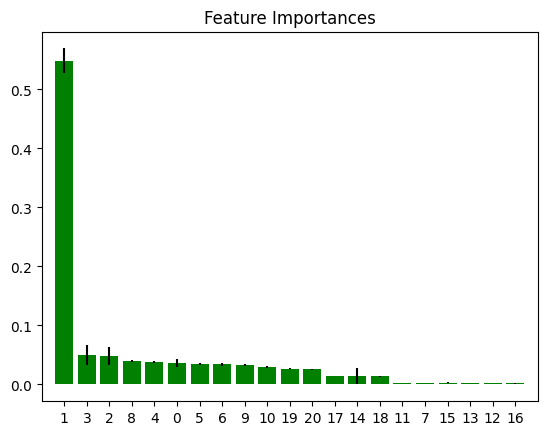

In [52]:
importances = forest.feature_importances_      # Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]        # Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='g', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

### 5.2. Definir o período de datas

In [53]:
# Definir as datas
data_inicial = datetime.strptime('2023-01-07', '%Y-%m-%d')
data_final   = datetime.strptime('2023-11-18', '%Y-%m-%d')

# Calcular a diferença em dias
diferenca_dias = (data_final - data_inicial).days

# Calcular 80% da diferença em dias
dias_limite = diferenca_dias * 0.8

# Somar a data inicial com os dias limite
data_limite = data_inicial + timedelta(days=dias_limite)

# Exibir a data limite
print(f'A data limite é: {data_limite.strftime("%Y-%m-%d")}')

A data limite é: 2023-09-16


In [54]:
# Definir os limites de datas
limite_data_teste = '2023-09-16'

# Definir o dataset de treino
X_train_full_FUll = df5.copy()
Y_train_full      = X_train_full_FUll['vendas_semanais']

# Definir o dataset de treino
X_train_full      = df5[df5['data'] < limite_data_teste]
Y_train           = X_train_full['vendas_semanais']

# Definir o dataset de teste
X_test_full       = df5[df5['data'] >= limite_data_teste]
Y_test            = X_test_full['vendas_semanais']

# Exibir os limites de datas
min_xtrain        = X_train_full['data'].min()
max_xtrain        = X_train_full['data'].max()

min_xtest         = X_test_full['data'].min()
max_xtest         = X_test_full['data'].max()

print(f'Limites do X_train: {min_xtrain} - {max_xtrain}')
print(f'Limites do X_test: {min_xtest} - {max_xtest}')

Limites do X_train: 2023-01-07 00:00:00 - 2023-09-09 00:00:00
Limites do X_test: 2023-09-16 00:00:00 - 2023-11-18 00:00:00


# IV. Modelagem

## 6. MACHINE LEARNING MODELING

In [55]:
X_train = X_train_full.drop(['id', 'vendas_semanais', 'data'], axis=1)
X_test  = X_test_full.drop(['id', 'vendas_semanais', 'data'], axis=1)

### 6.1. Treinar, testar e medir

#### 6.1.1 Linear Regression

In [64]:
%%time
# Criar uma instância do modelo de regressão linear
modelo_regressao = LinearRegression()

# Treinar o modelo com os dados de treinamento
modelo_regressao.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_lr = modelo_regressao.predict(X_test)

# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_lr)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 202273.69256440614
CPU times: total: 203 ms
Wall time: 165 ms


In [68]:
# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(y_pred_lr))
lr_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,Linear Regression,58275.683623,21.020743,4.091465e+10,202273.692564,-0.074016


In [69]:
lr_cv = cross_validation(X_train_full, 5, 'Linear Regression', modelo_regressao, verbose=True)
lr_cv

K = 5
K = 4
K = 3
K = 2
K = 1


,Model Name,RSME CV
0,Linear Regression,208397.91 +/- 1253.01


#### 6.1.2 Lasso

In [70]:
%%time
# Criar uma instância do modelo Lasso
modelo_lasso = Lasso(alpha=1.0, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_lasso.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_lasso = modelo_lasso.predict(X_test)

# Calcular o RMSE
rmse_lasso = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_lasso)))
print(f"Root Mean Squared Error (RMSE) para Regressão Lasso: {rmse_lasso}")

Root Mean Squared Error (RMSE) para Regressão Lasso: 202701.18127561567
CPU times: total: 93.8 ms
Wall time: 93.5 ms


In [105]:
# Performance
lasso_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(y_pred_lasso))
lasso_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,Linear Regression - Lasso,58632.79288,24.681398,4.108777e+10,202701.181276,-0.07856


In [72]:
%%time
lasso_cv = cross_validation(X_train_full,5,'Linear Regression - Lasso', modelo_lasso, verbose=True)
lasso_cv 

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 1.33 s
Wall time: 545 ms


,Model Name,RSME CV
0,Linear Regression - Lasso,208847.92 +/- 1230.44


#### 6.1.3 Random Forest

In [73]:
%%time
# Criar uma instância do modelo de Random Forest
modelo_random_forest = en.RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Treinar o modelo com os dados de treinamento
modelo_random_forest.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_rf = modelo_random_forest.predict(X_test)

# Calcular o RMSE
rmse_rf = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_rf)))
print(f"Root Mean Squared Error (RMSE) para Random Forest: {rmse_rf}")

Root Mean Squared Error (RMSE) para Random Forest: 198268.2769354889
CPU times: total: 1min 49s
Wall time: 15.2 s


In [107]:
# Performance
rf_result = ml_error('Random Forest', np.expm1(Y_test), np.expm1(y_pred_rf))
rf_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,Random Forest,54265.122607,2.930018,3.931031e+10,198268.276935,-0.031902


In [75]:
%%time
rf_cv = cross_validation(X_train_full,5,'Random Forest',modelo_random_forest,verbose=True)
rf_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 3min 42s
Wall time: 32.9 s


,Model Name,RSME CV
0,Random Forest,205103.3 +/- 1315.44


#### 6.1.4 XGBoost

In [78]:
%%time
# Criar uma instância do modelo XGBoost
modelo_xgboost = XGBRegressor(n_estimators=100, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_xgboost.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_xgb = modelo_xgboost.predict(X_test)

# Calcular o RMSE
rmse_xgboost = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_xgb)))
print(f"Root Mean Squared Error (RMSE) para XGBoost: {rmse_xgboost}")

Root Mean Squared Error (RMSE) para XGBoost: 198894.41303392552
CPU times: total: 23.3 s
Wall time: 3.37 s


In [104]:
# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(y_pred_xgb))
xgb_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,XGBoost Regressor,50594.601173,1.516954,3.955899e+10,198894.413034,-0.038429


In [80]:
%%time
xgb_cv = cross_validation(X_train_full,5,'XGBoost', modelo_xgboost, verbose=True)
xgb_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 52.5 s
Wall time: 7.86 s


,Model Name,RSME CV
0,XGBoost,206824.68 +/- 2026.73


#### 6.1.5 LGBM Model

In [81]:
%%time
# Criar uma instância do modelo LightGBM
modelo_lgbm = LGBMRegressor(n_estimators=100, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_lgbm.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_lgbm = modelo_lgbm.predict(X_test)

# Calcular o RMSE
rmse_lgbm = np.sqrt(mean_squared_error(np.expm1(Y_test),np.expm1(y_pred_lgbm)))
print(f"Root Mean Squared Error (RMSE) para LightGBM: {rmse_lgbm}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 95385, number of used features: 19
[LightGBM] [Info] Start training from score 8.787567
Root Mean Squared Error (RMSE) para LightGBM: 199271.3479651534
CPU times: total: 2.42 s
Wall time: 1.71 s


In [103]:
# Performance
lgbm_result = ml_error('LGBM Model', np.expm1(Y_test), np.expm1(y_pred_lgbm))
lgbm_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,LGBM Model,50570.713724,1.798876,3.970907e+10,199271.347965,-0.042369


In [83]:
%%time
lgbm_cv = cross_validation(X_train_full,5,'LGBM Model', modelo_lgbm, verbose=True)
lgbm_cv

K = 5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 13211, number of used features: 17
[LightGBM] [Info] Start training from score 8.684756
K = 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 29213, number of used features: 19
[LightGBM] [Info] Start training from score 8.760524
K = 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

,Model Name,RSME CV
0,LGBM Model,205630.23 +/- 1231.93


#### 6.1.6 Elastic Net

In [84]:
%%time
# Criar uma instância do modelo Elastic Net
modelo_elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_elasticnet.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_elasticnet = modelo_elasticnet.predict(X_test)

# Calcular o RMSE
rmse_elasticnet = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_elasticnet)))
print(f"Root Mean Squared Error (RMSE) para Elastic Net: {rmse_elasticnet}")

Root Mean Squared Error (RMSE) para Elastic Net: 202684.0419498248
CPU times: total: 125 ms
Wall time: 91.5 ms


In [102]:
# Performance
elasticnet_result = ml_error('Elastic Net', np.expm1(Y_test), np.expm1(y_pred_elasticnet))
elasticnet_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,Elastic Net,58635.760399,24.605752,4.108082e+10,202684.04195,-0.078378


In [86]:
%%time
elastic_cv = cross_validation(X_train_full,5,'Elastic Net', modelo_elasticnet, verbose=True)
elastic_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 1.17 s
Wall time: 455 ms


,Model Name,RSME CV
0,Elastic Net,208830.75 +/- 1230.47


#### 6.1.7 K-Nearest Neighbors (KNN) Regression

In [87]:
%%time
# Criar uma instância do modelo KNN Regressor
modelo_knn = KNeighborsRegressor(n_neighbors=7)  # O número de vizinhos (n_neighbors) é um exemplo, ajuste conforme necessário

# Treinar o modelo com os dados de treinamento
modelo_knn.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_knn = modelo_knn.predict(X_test)

# Calcular o RMSE
rmse_knn = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_knn)))
print(f"Root Mean Squared Error (RMSE) para K-Nearest Neighbors Regression: {rmse_knn}")

Root Mean Squared Error (RMSE) para K-Nearest Neighbors Regression: 199835.93320336434
CPU times: total: 1min 49s
Wall time: 1min 54s


In [101]:
# Performance
knn_result = ml_error('KNN', np.expm1(Y_test), np.expm1(y_pred_knn))
knn_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,KNN,54639.495608,8.451232,3.993440e+10,199835.933203,-0.048284


In [89]:
%%time
knn_cv = cross_validation(X_train_full, 5, 'KNN', modelo_knn, verbose=True)
knn_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 2min 54s
Wall time: 2min 54s


,Model Name,RSME CV
0,KNN,206201.62 +/- 1230.22


#### 6.1.8 Ridge

In [90]:
%%time
# Criar uma instância do modelo Ridge
modelo_ridge = Ridge(alpha=1.0, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_ridge.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_ridge = modelo_ridge.predict(X_test)

# Calcular o RMSE
rmse_ridge = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_ridge)))
print(f"Root Mean Squared Error (RMSE) para Ridge Regression: {rmse_ridge}")

Root Mean Squared Error (RMSE) para Ridge Regression: 202271.9688272989
CPU times: total: 141 ms
Wall time: 105 ms


In [109]:
# Performance
ridge_result = ml_error('Ridge', np.expm1(Y_test), np.expm1(y_pred_ridge))
ridge_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,Ridge,58275.484789,21.036826,4.091395e+10,202271.968827,-0.073997


In [114]:
%%time
ridge_cv = cross_validation(X_train_full,5,'Ridge',modelo_ridge,verbose=True)
ridge_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 1.2 s
Wall time: 474 ms


,Model Name,RSME CV
0,Ridge,208394.03 +/- 1258.27


#### 6.1.9 Gradient Boosting Regressor

In [97]:
%%time
# Criar uma instância do modelo Gradient Boosting Regressor
modelo_gradient_boosting = GradientBoostingRegressor(n_estimators=250, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_gradient_boosting.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_gb = modelo_gradient_boosting.predict(X_test)

# Calcular o RMSE
rmse_gradient_boosting = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(y_pred_gb)))
print(f"Root Mean Squared Error (RMSE) para Gradient Boosting Regressor: {rmse_gradient_boosting}")

Root Mean Squared Error (RMSE) para Gradient Boosting Regressor: 199488.88580753672
CPU times: total: 43 s
Wall time: 1min 13s


In [111]:
# Performance
gbr_result = ml_error('GBR', np.expm1(Y_test), np.expm1(y_pred_gb))
gbr_result

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,GBR,51215.132182,3.633502,3.979582e+10,199488.885808,-0.044646


In [99]:
%%time
gbr_cv = cross_validation(X_train_full,5,'GBR',modelo_gradient_boosting,verbose=True)
gbr_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 1min 43s
Wall time: 2min 35s


,Model Name,RSME CV
0,GBR,205832.15 +/- 1235.7


### 6.2. Validar métricas

In [112]:
modelling_result = pd.concat([lr_result, lasso_result, rf_result, lgbm_result, knn_result, elasticnet_result, xgb_result, ridge_result, gbr_result])
modelling_result.sort_values('RMSE').reset_index(drop=True)

,Model Name,MAE,MAPE,MSE,RMSE,R2
0,Random Forest,54265.122607,2.930018,3.931031e+10,198268.276935,-0.031902
1,XGBoost Regressor,50594.601173,1.516954,3.955899e+10,198894.413034,-0.038429
2,LGBM Model,50570.713724,1.798876,3.970907e+10,199271.347965,-0.042369
3,GBR,51215.132182,3.633502,3.979582e+10,199488.885808,-0.044646
4,GBR,51215.132182,3.633502,3.979582e+10,199488.885808,-0.044646
5,KNN,54639.495608,8.451232,3.993440e+10,199835.933203,-0.048284
6,Ridge,58275.484789,21.036826,4.091395e+10,202271.968827,-0.073997
7,Elastic Net,58635.760399,24.605752,4.108082e+10,202684.041950,-0.078378
8,Linear Regression - Lasso,58632.792880,24.681398,4.108777e+10,202701.181276,-0.078560


In [118]:
pd.concat([lr_cv, lasso_cv, rf_cv, xgb_cv, lgbm_cv, elastic_cv, knn_cv, ridge_cv, gbr_cv])

,Model Name,RSME CV
0,Linear Regression,208397.91 +/- 1253.01
0,Linear Regression - Lasso,208847.92 +/- 1230.44
0,Random Forest,205103.3 +/- 1315.44
0,XGBoost,206824.68 +/- 2026.73
0,LGBM Model,205630.23 +/- 1231.93
0,Elastic Net,208830.75 +/- 1230.47
0,KNN,206201.62 +/- 1230.22
0,Ridge,208394.03 +/- 1258.27
0,GBR,205832.15 +/- 1235.7


## 7. HYPERPARAMETER FINE TUNING

### 7.1. Random Search

In [122]:
# Definindo parâmetros aleatórios para o Random Search
param_lgbm = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, -1],  # -1 indica sem limite de profundidade
    'learning_rate': [0.5, 0.4, 0.3],
    'num_leaves': [31, 50, 75, 100, 150],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30, 40, 50]
}

max_eval = 10

In [ ]:
# Armazenar os resultados
final_result = pd.DataFrame()

for i in range(max_eval):
    # Escolher valores para parâmetros aleatoriamente
    hp_rf = {k: random.sample(v, 1)[0] for k, v in param_lgbm.items()}
    print(hp_rf)
    
    # Criar uma instância do modelo LGBMRegressor
    modelo_lgbm = LGBMRegressor(
        n_estimators=hp_rf['n_estimators'],
        max_depth=hp_rf['max_depth'],
        learning_rate=hp_rf['learning_rate'],
        num_leaves=hp_rf['num_leaves'],
        subsample=hp_rf['subsample'],
        colsample_bytree=hp_rf['colsample_bytree'],
        min_child_samples=hp_rf['min_child_samples'],
        random_state=42,
        n_jobs=-1
    )

    # Performance usando cross-validation
    result = cross_validation(X_train_full_FUll,5,f'LGBM: {i+1}',modelo_lgbm,verbose=True)

    final_result = pd.concat([final_result,result])

In [124]:
final_result

,Model Name,RSME CV
0,LGBM: 1,202601.61 +/- 3759.67
0,LGBM: 2,202500.33 +/- 3788.36
0,LGBM: 3,202723.9 +/- 3787.58
0,LGBM: 4,202550.05 +/- 3766.54
0,LGBM: 5,205088.2 +/- 7018.11
0,LGBM: 6,202576.68 +/- 3768.84
0,LGBM: 7,202568.78 +/- 3722.12
0,LGBM: 8,202624.69 +/- 3781.85
0,LGBM: 9,202678.5 +/- 3725.43
0,LGBM: 10,202507.49 +/- 3786.47


In [125]:
param_lgbm = {
    'n_estimators': 200,
    'max_depth': 15,  # -1 indica sem limite de profundidade
    'learning_rate': 0.2,
    'num_leaves': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'min_child_samples': 20
}

In [126]:
modelo_lgbm = LGBMRegressor(
        n_estimators=param_lgbm['n_estimators'],
        max_depth=param_lgbm['max_depth'],
        learning_rate=param_lgbm['learning_rate'],
        num_leaves=param_lgbm['num_leaves'],
        subsample=param_lgbm['subsample'],
        colsample_bytree=param_lgbm['colsample_bytree'],
        min_child_samples=param_lgbm['min_child_samples'],
        n_jobs=-1
    )

# Treinar o modelo com os dados de treinamento
modelo_lgbm.fit(X_train_full_FUll.drop(['id','vendas_semanais','data'],axis=1), Y_train_full)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 121996, number of used features: 21
[LightGBM] [Info] Start training from score 8.788319


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.2, max_depth=15,
              n_estimators=200, n_jobs=-1, num_leaves=100, subsample=0.8)

# V. Validação

## 8. ERROR TRANSLATION AND INTERPRETATION

In [129]:
X_test

,loja,setor,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,...,desconto,feriado_0,feriado_1,tipo_de_loja_A,tipo_de_loja_B,tipo_de_loja_C,week_of_month_sin,week_of_month_cos,day_sin,day_cos
2202,17,87,1,-0.770246,7.734776e-02,3.641,0.06745,0.0,0.116232,0.8,...,0.000000,1,0,1,0,0,-1.0,-1.836970e-16,-0.207912,-0.978148
2203,17,29,1,-0.770246,7.734776e-02,3.641,0.06745,0.0,0.116232,0.8,...,0.000000,1,0,1,0,0,-1.0,-1.836970e-16,-0.207912,-0.978148
2204,17,46,1,-0.770246,7.734776e-02,3.641,0.06745,0.0,0.116232,0.8,...,0.000000,1,0,1,0,0,-1.0,-1.836970e-16,-0.207912,-0.978148
2205,17,93,1,-0.770246,7.734776e-02,3.641,0.06745,0.0,0.116232,0.8,...,0.000000,1,0,1,0,0,-1.0,-1.836970e-16,-0.207912,-0.978148
2206,17,91,1,-0.770246,7.734776e-02,3.641,0.06745,0.0,0.116232,0.8,...,0.000000,1,0,1,0,0,-1.0,-1.836970e-16,-0.207912,-0.978148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121991,33,90,0,-1.847837,1.255991e-14,3.669,0.08010,-298048.0,0.155311,1.0,...,0.044138,1,0,1,0,0,-1.0,-1.836970e-16,-0.587785,-0.809017
121992,33,96,0,-1.847837,1.255991e-14,3.669,0.08010,-298048.0,0.155311,1.0,...,0.044138,1,0,1,0,0,-1.0,-1.836970e-16,-0.587785,-0.809017
121993,33,95,0,-1.847837,1.255991e-14,3.669,0.08010,-298048.0,0.155311,1.0,...,0.044138,1,0,1,0,0,-1.0,-1.836970e-16,-0.587785,-0.809017
121994,33,98,0,-1.847837,1.255991e-14,3.669,0.08010,-298048.0,0.155311,1.0,...,0.044138,1,0,1,0,0,-1.0,-1.836970e-16,-0.587785,-0.809017


### 8.1. Business Performance

### 8.2. Total Performance

### 8.3. Machine Learning Performance

# VI. Implantação

## 9. DEPLOY / SUBMISSION

### 9.1.1. Deploy

In [131]:
# 0. IMPORTS
test          = pd.read_csv('datasets/test.csv', low_memory=False)
test_features = pd.read_csv('datasets/test_features.csv', low_memory=False)

#          1. DATA DESCRIPTION
##       1.1. Unir tabelas

df_test = pd.merge(test, stores, on='loja', how='inner')
df_teste = pd.merge(df_test, test_features, on=['loja', 'data', 'feriado'], how='inner')

#          2. TRATAMENTO E FILTRAGEM DE VARIÁVEIS
##       2.2. Transformar e converter
###    2.2.1. Preencher NA´s

#### 2.2.1.2. Preencher os descontos com valores nulos com 0
df_teste['desconto_1'] = df_teste['desconto_1'].fillna(0)
df_teste['desconto_2'] = df_teste['desconto_2'].fillna(0)
df_teste['desconto_3'] = df_teste['desconto_3'].fillna(0)
df_teste['desconto_4'] = df_teste['desconto_4'].fillna(0)
df_teste['desconto_5'] = df_teste['desconto_5'].fillna(0)

#### 2.2.1.3. Preencher o tamanho das lojas faltantes com a mediana
mediana = df_teste['tamanho'].median()
tam_faltantes2 = df_teste.loc[df_teste['tamanho'].isna(), :].index
df_teste['tamanho'] = df_teste['tamanho'].apply(lambda x: mediana if math.isnan(x) else x)

#### 2.2.1.4. Preencher a temperatura faltantes usando a média
media = df_teste['temperatura'].mean()
temp_faltantes2 = df_teste.loc[df_teste['temperatura'].isna(), :].index
df_teste['temperatura'] = df_teste['temperatura'].apply(lambda x: media if math.isnan(x) else x)

#### 2.2.1.5. Preencher os registros com combustível faltantes usando a média
media = df_teste['combustivel'].mean()
comb_faltantes2 = df_teste.loc[df_teste['combustivel'].isna(), :].index
df_teste['combustivel'] = df_teste['combustivel'].apply(lambda x: media if math.isnan(x) else x)

#### 2.2.1.6. Preencher os registros com distancia faltantes usando um número grande
comp_faltantes2 = df_teste.loc[df_teste['distancia_competidores'].isna(), :].index
df_teste['distancia_competidores'] = df_teste['distancia_competidores'].apply(lambda x: 300000 if math.isnan(x) else x)

###    2.2.2. Transformação de tipos
#### 2.2.2.1 Transformar data nas colunas dia e mes

df_teste['data']= pd.to_datetime(df_teste['data'] + '-2023', format='%m-%d-%Y')
df_teste["week_of_year"] = df_teste["data"].dt.strftime("%U")
df_teste["week_of_month"] = df_teste["data"].dt.day.apply(lambda x: (x - 1) // 7 + 1)
df_teste['month'] = df_teste['data'].dt.month
df_teste['day'] = df_teste['data'].dt.day

#### 2.2.2.2. Transformar feriado em 0 e 1
df_teste['feriado'] = df_teste['feriado'].apply(lambda x: 1 if x == 'sim' else 0)

##       2.3. Criar
###    2.3.1. Classificar as lojas pelo tamanho
q1 = df2['tamanho'].quantile(0.25)
q2 = df2['tamanho'].quantile(0.5)
q3 = df2['tamanho'].quantile(0.75)

df_teste['tipo_de_loja'] = df_teste['tamanho'].apply(lambda x: 'A' if x < q1 else
                                                     'B' if x < q3 else 'C')

###    2.3.2. Somar os desconto semana
df_teste['desconto'] = df_teste['desconto_1'] + df_teste['desconto_2'] + df_teste['desconto_3'] + df_teste['desconto_4'] + df_teste['desconto_5']
df_teste.drop(['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5'], axis=1, inplace=True)

#          4. DATA PREPARATION
df_teste_dt = df_teste.copy()
df_teste['week_of_year'] = df_teste['week_of_year'].astype(int)

##       4.1 Variáveis Numéricas
df_teste_dt['tamanho']      = ss.fit_transform(df_teste_dt[['tamanho']])
df_teste_dt['temperatura']  = ss.fit_transform(df_teste_dt[['temperatura']])
df_teste_dt['desconto']     = mm.fit_transform(df_teste_dt[['desconto']])
df_teste_dt['week_of_year'] = mm.fit_transform(df_teste_dt[['week_of_year']])
df_teste_dt['clientes']     = mm.fit_transform(df_teste_dt[['clientes']])
df_teste_dt['distancia_competidores'] = rs.fit_transform(df_teste_dt[['distancia_competidores']])

##       4.2 Variáveis Categóricas
df_teste_dt         = pd.get_dummies(df_teste_dt,prefix=['feriado'],dtype='int64',columns=['feriado'])
df_teste_dt['tipo'] = le.fit_transform(df_teste_dt['tipo'])
df_teste_dt         = pd.get_dummies(df_teste_dt,prefix=['tipo_de_loja'],dtype='int64',columns=['tipo_de_loja'])

df_teste_dt['week_of_month_sin'] = df_teste_dt['week_of_month'].apply(lambda x: np.sin(x * (2 * np.pi / 4))) 
df_teste_dt['week_of_month_cos'] = df_teste_dt['week_of_month'].apply(lambda x: np.cos(x * (2 * np.pi / 4)))
df_teste_dt = df_teste_dt.drop(['week_of_month'],axis=1)

df_teste_dt['day_sin'] = df_teste_dt['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30))) 
df_teste_dt['day_cos'] = df_teste_dt['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
df_teste_dt = df_teste_dt.drop(['day'],axis=1)

### 9.2. Submission

In [132]:
teste      = df_teste_dt.drop(['id','data'],axis=1)
y_hat_test = modelo_lgbm.predict(teste)

In [133]:
final_test = pd.concat([df_teste_dt, pd.Series(np.expm1(y_hat_test), name='vendas_semanais')], axis=1)
final_test[['id', 'vendas_semanais']].sort_values('id',ascending=True).to_csv('datasets/submission2_8.csv', index=False)